# Tutorial 4 - Setting parameter values

In [Tutorial 1](./Tutorial%201%20-%20How%20to%20run%20a%20model.ipynb) and [Tutorial 2](./Tutorial%202%20-%20Compare%20models.ipynb), we saw how to run a PyBaMM model with all the default settings. However, PyBaMM also allows you to tweak these settings for your application. In this tutorial, we will see how to change the parameters in PyBaMM.

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


## Change the whole parameter set

PyBaMM has a number of in-built parameter sets (check the list [here](https://pybamm.readthedocs.io/en/latest/source/parameters/parameter_sets.html)), which can be selected doing

In [2]:
chemistry = pybamm.parameter_sets.Chen2020

This variable is a dictionary with the corresponding parameter subsets for each component.

In [3]:
chemistry

{'chemistry': 'lithium-ion',
 'cell': 'LGM50_Chen2020',
 'negative electrode': 'graphite_Chen2020',
 'separator': 'separator_Chen2020',
 'positive electrode': 'nmc_Chen2020',
 'electrolyte': 'lipf6_Nyman2008',
 'experiment': '1C_discharge_from_full_Chen2020',
 'sei': 'example',
 'citation': 'Chen2020'}

More details on each subset can be found [here](https://github.com/pybamm-team/PyBaMM/tree/master/pybamm/input/parameters).

Now we can pass `'chemistry'` into `ParameterValues` to create the dictionary of parameter values

In [4]:
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

We can see all the parameters stored in the dictionary

In [5]:
parameter_values

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell capacity [A.h]': 5.0,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell volume [m3]': 2.42e-05,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008 at 0x7ffc624510e0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008 at 0x7ffc62441e60>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial concentration in positive electrode [mol.m-3]': 17038.0,
 'Initial inner SEI thickness [m]': 2.5e-09,
 'Initial outer SEI thickness [m]': 2.5e-09,
 'Initial temperature [K]': 298.15,
 'Inner SEI electron conductivity [S.m

or we can search for a particular parameter

In [6]:
parameter_values.search("electrolyte")

EC initial concentration in electrolyte [mol.m-3]	4541.0
Electrolyte conductivity [S.m-1]	<function electrolyte_conductivity_Nyman2008 at 0x7ffc624510e0>
Electrolyte diffusivity [m2.s-1]	<function electrolyte_diffusivity_Nyman2008 at 0x7ffc62441e60>
Initial concentration in electrolyte [mol.m-3]	1000.0
Negative electrode Bruggeman coefficient (electrolyte)	1.5
Positive electrode Bruggeman coefficient (electrolyte)	1.5
Separator Bruggeman coefficient (electrolyte)	1.5
Typical electrolyte concentration [mol.m-3]	1000.0


To run a simulation with this parameter set, we can proceed as usual but passing the parameters as a keyword argument

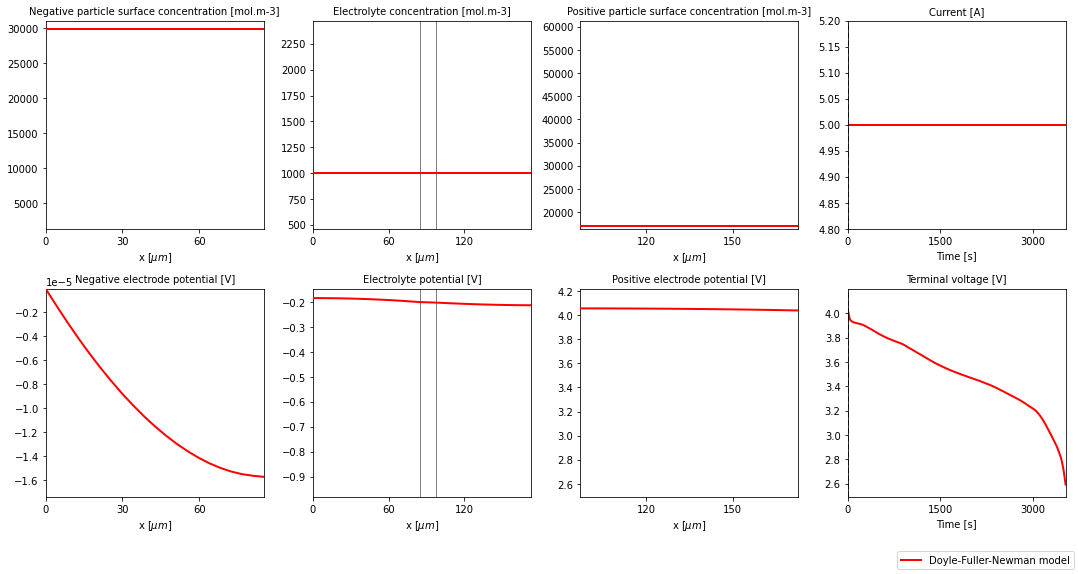

In [7]:
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0, 3600])
sim.plot()

## Change individual parameters

We often want to quickly change a small number of parameter values to investigate how the behaviour or the battery changes. In such cases, we can change parameter values without having to leave the notebook or script you are working in. 

We start initialising the model and the parameter values

In [8]:
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

In this example we will change the current to 10 A

In [9]:
parameter_values["Current function [A]"] = 10

Now we just need to run the simulation with the new parameter values

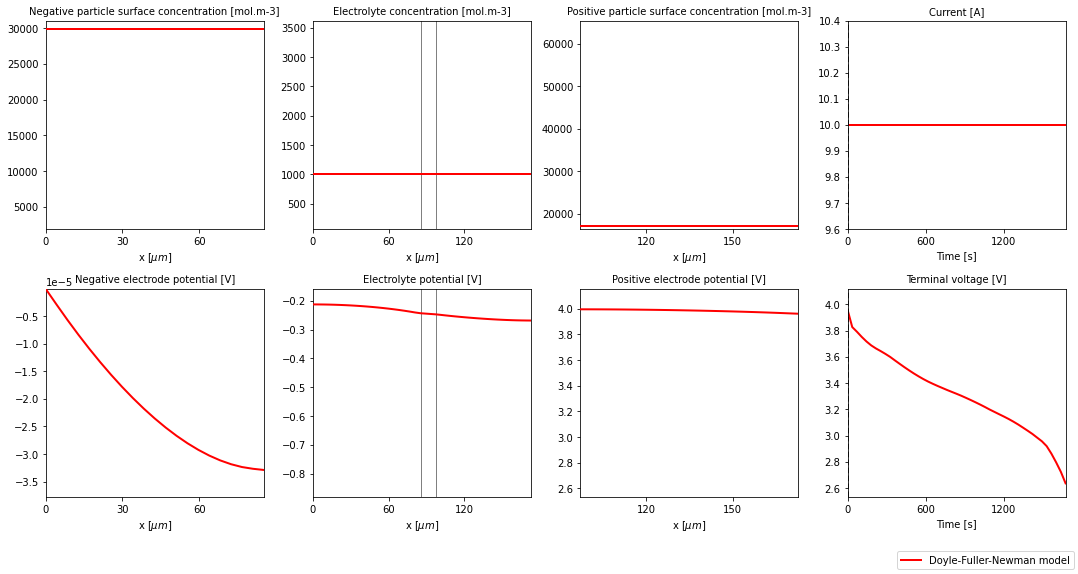

In [10]:
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0, 3600])
sim.plot()

Note that we still passed the interval `[0, 3600]` to `sim.solve()`, but the simulation terminated early as the lower voltage cut-off was reached.

### Drive cycle

You can implement drive cycles importing the dataset and creating an interpolant to pass as the current function.

In [11]:
import pandas as pd    # needed to read the csv data file

# Import drive cycle from file
drive_cycle = pd.read_csv("pybamm/input/drive_cycles/US06.csv", comment="#", header=None).to_numpy()

# Create interpolant
timescale = parameter_values.evaluate(model.timescale)
current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t)

# Set drive cycle
parameter_values["Current function [A]"] = current_interpolant

Note that your drive cycle data can be stored anywhere, you just need to pass the path of the file. Then, again, the model can be solved as usual but notice that now, if `t_eval` is not specified, the solver will take the time points from the data set.

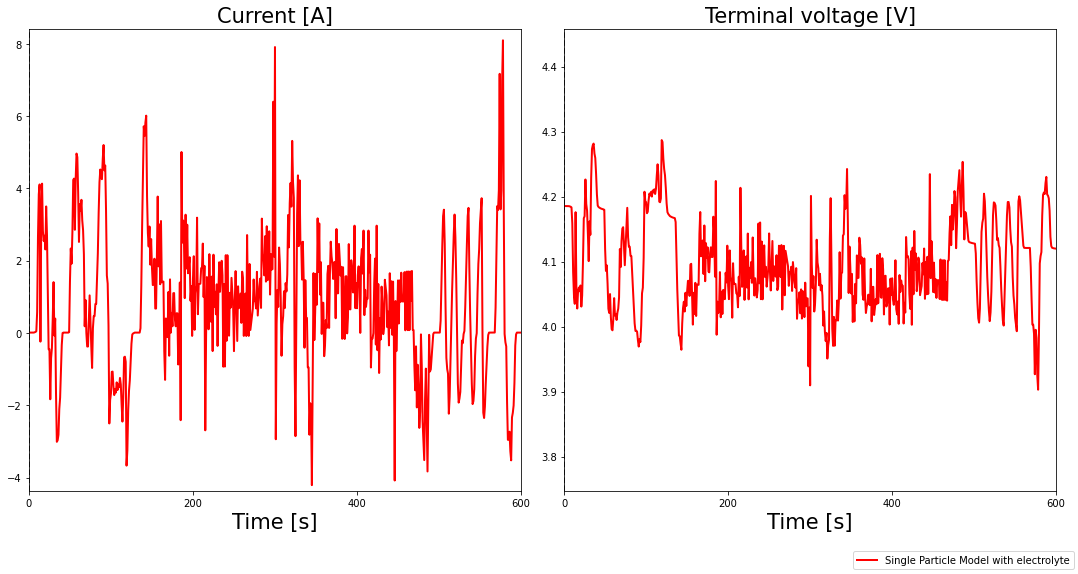

In [12]:
model = pybamm.lithium_ion.SPMe()
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve()
sim.plot(["Current [A]", "Terminal voltage [V]"])

### Custom current function

Alternatively, we can define the current to be an arbitrary function of time

In [13]:
import numpy as np

def my_current(t):
    return pybamm.sin(2 * np.pi * t / 60)

parameter_values["Current function [A]"] = my_current

and we can now solve the model again. In this case, we can pass `t_eval` to the solver to make sure we have enough time points to resolve the function in our output.

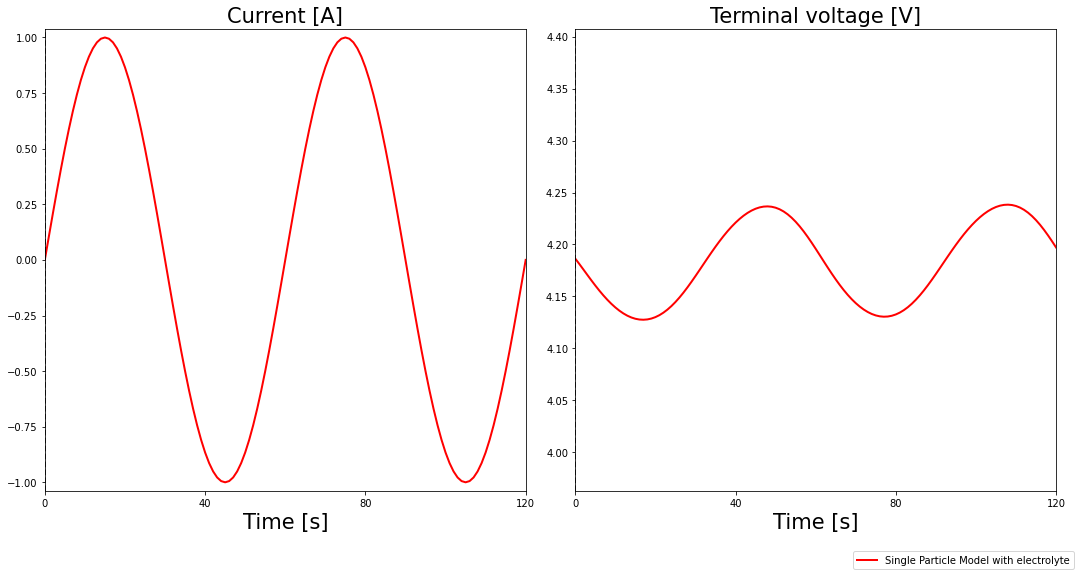

In [14]:
model = pybamm.lithium_ion.SPMe()
sim = pybamm.Simulation(model, parameter_values=parameter_values)
t_eval = np.arange(0, 121, 1)
sim.solve(t_eval=t_eval)
sim.plot(["Current [A]", "Terminal voltage [V]"])

In this notebook we have seen how we can change the parameters of our model. In [Tutorial 5](./Tutorial%205%20-%20Run%20experiments.ipynb) we show how can we define and run experiments.

## References

The relevant papers for this notebook are:

In [15]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with